# Crime Prediction using Tweets and KDE

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook


from utils.consts import START_DATE, END_DATE, KDE_BANDWITH, LDA_PARAMS, LDA_TOPICS, \
                         CSV_DATE_FORMART


from utils.geo import latlng2grid_cords_chicago, \
                      latlng2LDA_topics_chicago, \
                      generate_chicago_threat_grid_list, \
                      enrich_with_chicago_grid_200, \
                      CHICAGO_UTM_COORDS, FALSE_LABLE_DATASET_CELL_SIZE, \
                      N_CHICAGO_THREAT_GRID_LIST

In [2]:
RAW_CRIMES_DATA_PATH = os.path.join('data', 'raw', 'Crimes_-_2001_to_present.csv')
PROCESSED_CRIMES_DATA_PATH = os.path.join('data', 'processed', 'crime_data.csv')

RAW_TWEETS_DATA_WILDCARD_PATH = ('"' +
                                 os.path.join('data', 'raw', 'tweets', '*.json') +
                                 '"')
PROCESSED_TWEETS_DATA_PATH = os.path.join('data', 'processed', 'tweets_data.csv')

![title](./ANLP-Project-Pipeline.png)

## Research Time Frame

In [3]:
print(START_DATE, '--->', END_DATE)

2017-12-08 ---> 2018-02-19


## Data Sources & Preprocessing

### Chicago Crimes Incidents

In [4]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

In [5]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)
crimes_data['timestamp'] = pd.to_datetime(crimes_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()

In [6]:
len(crimes_data)

10902

In [7]:
crimes_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

### Tweets

In [8]:
if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

In [9]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [10]:
len(tweets_data)

79634

In [11]:
tweets_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

#### Tweets document groupping by geo-location

In [12]:
def generate_tweets_docs(tweets_data):
    tweet_docs_groupby = tweets_data.groupby(('latitude_index', 'longitude_index'))
    tweet_docs = tweet_docs_groupby['tokens'].apply(lambda r: list(r)).apply(lambda r: sum(r, []))
    tweet_docs = tweet_docs.sort_index()
    return tweet_docs

## Feature Extract Functions

### KDE

In [13]:
from sklearn.neighbors.kde import KernelDensity

def train_KDE_model(train_df, bandwith=KDE_BANDWITH):
    '''
    Train KDE model.

    Input:
    train_df: train data frame with Latitude Logitude. 3 months prior data for the day of surveillance..

    Output:
    KDE Model
    '''
    
    kde = KernelDensity(bandwidth=bandwith,
                        metric='haversine',
                        kernel='gaussian',
                        algorithm='ball_tree')
    
    kde.fit(train_df[['latitude','longitude']])
    
    return kde

In [14]:
crimes_kde_model = train_KDE_model(crimes_data)

### TODO - visualization

### Sentiment Analysis

### LDA

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def coalesce(token):
    '''
    Klaues: why this function?
    '''
    new_tokens = []
    for char in token:
        if len(new_tokens) < 2 or char != new_tokens[-1] or char != new_tokens[-2]:
            new_tokens.append(char)
    return ''.join(new_tokens)

def preprocess_tweet_for_LDA(raw_tokens):
    '''
    text input is one string
    output is tokenized and preprocessed(as defined below) text
    
    lowercase
    no hashtags or mentions
    any url converted to "url"
    replace multiple repeated chars with 2 of them. eg paaaarty -> paarty
    '''
    
    processed_tokens = []
    for token in raw_tokens:
        if token.startswith("@") or token.startswith("#"):
            continue
        elif token.startswith("https://") or token.startswith("http://"):
            processed_tokens.append("url")
        else:
            processed_tokens.append(coalesce(token))
            
    return processed_tokens

def train_LDA_model(docs, params=LDA_PARAMS, preprocessor=preprocess_tweet_for_LDA):
    
    vectorizer = CountVectorizer(stop_words="english",
                                 preprocessor=preprocessor,
                                 tokenizer=lambda x:x)
    
    lda_train_data = vectorizer.fit_transform(docs)
    
    lda_model = LatentDirichletAllocation(**params)

    lda_model.fit(lda_train_data)
    
    doc_topics = lda_model.transform(lda_train_data)
    
    vocabulary = vectorizer.get_feature_names()
    
    return lda_model, doc_topics, vocabulary

In [16]:
def get_topic_top_words_LDA(topic_index, lda_model, vocabulary, n_top_words):
    topic = lda_model.components_[topic_index]
    return [vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            
def print_top_words_LDA(lda_model, vocabulary, n_top_words):
    for topic_idx in range(len(lda_model.components_)):
        
        message = "Topic #%d: " % topic_index
        message += " | ".join(get_topic_top_words_LDA(topic_index, lda_model, vocabulary, n_top_words))

        print(message)
    print()
    
# print_top_words_LDA(tweets_lda_model, tweets_vocabulary, 5)    



## Generate Train & Evaluatuin Datasets Functions

In [92]:
def generate_one_step_train_dataset(crimes_dataset, tweets_dataset):
    crimes_kde_model = train_KDE_model(crimes_dataset)
    
    tweets_docs = generate_tweets_docs(tweets_dataset)
    
    tweets_lda_model, doc_topics, tweets_vocabulary = train_LDA_model(tweets_docs.tolist())
    
    get_tweets_topic_top_words_LDA = functools.partial(get_topic_top_words_LDA,
                                                       lda_model=tweets_lda_model,
                                                       vocabulary=tweets_vocabulary,
                                                       n_top_words=5)

    latlng2LDA_tweet_topics_chicago = functools.partial(latlng2LDA_topics_chicago,
                                                    doc_topics=doc_topics,
                                                    docs=tweets_docs)

    chicago_grid_mask = lambda lat, lng: latlng2grid_cords_chicago(lat, lng) in tweets_docs.index
    
    train_dataset = pd.concat([crimes_data[['latitude', 'longitude']].assign(crime=True),
                            generate_chicago_threat_grid_list().assign(crime=False)],
                    axis=0)


    train_dataset = train_dataset[['latitude', 'longitude', 'crime']]
    train_dataset = enrich_with_chicago_grid_200(train_dataset)

    train_dataset['KDE'] = crimes_kde_model.score_samples(
        train_dataset[['latitude', 'longitude']].as_matrix()
    )

    train_dataset[LDA_TOPICS] = train_dataset.apply(lambda row: pd.Series(latlng2LDA_tweet_topics_chicago(
                                                                    row['latitude'],
                                                                    row['longitude'])),
                                        axis=1)

    features_cols = ['KDE'] + LDA_TOPICS

    train_dataset = {
                    'X': train_dataset[['latitude_index', 'longitude_index'] + features_cols],
                    'Y': train_dataset['crime']
    }
    
    return train_dataset


def generate_one_step_evaluation_dataset(crimes_evaluation_dataset):
    evaluation_dataset = enrich_with_chicago_grid_200(crimes_evaluation_dataset)
    evaluation_dataset = evaluation_dataset[['latitude_index', 'longitude_index']]
    return evaluation_dataset


def generate_one_step_datasets(crimes_data, tweets_data, start_train_date, n_train_days):
    start_train_date = pd.to_datetime(start_train_date)

    end_train_date = start_train_date + pd.DateOffset(n_train_days)
    evaluation_date = end_train_date + pd.DateOffset(1)
    
    print(start_train_date, '|', end_train_date, '|', evaluation_date)
    crimes_train_dataset = crimes_data[(crimes_data['timestamp'] >= start_train_date) &
                                       ((crimes_data['timestamp'] <= end_train_date))]
    
    tweets_train_dataset = tweets_data[(tweets_data['timestamp'] >= start_train_date) &
                                       ((tweets_data['timestamp'] <= end_train_date))]
    
    crimes_evaluation_dataset = crimes_data[crimes_data['timestamp'] == evaluation_date]
    
    print('Crimes Train Dataset:')
    print(crimes_train_dataset['timestamp'].agg([len, 'min', 'max']))
      
    print('Tweets Train Dataset:')
    print(tweets_train_dataset['timestamp'].agg([len, 'min', 'max']))

    print('Crimes Evaluation Dataset:')
    print(crimes_evaluation_dataset['timestamp'].agg([len, 'min', 'max']))
    
    train_dataset = generate_one_step_train_dataset(crimes_train_dataset, tweets_train_dataset)
    evaluation_dataset = generate_one_step_evaluation_dataset(crimes_evaluation_dataset)
    
    return train_dataset, evaluation_dataset


In [18]:
from sklearn.linear_model import LogisticRegression

def generate_threat_kde_dataset(train_dataset):
    threat_grid_cells = train_dataset['X'][~train_dataset['Y']]
    kde_values = threat_grid_cells[['latitude_index', 'longitude_index', 'KDE']]
    threat_kde_df = kde_values.set_index(['latitude_index', 'longitude_index'])['KDE']
    threat_kde_df = threat_kde_df.sort_values(ascending=False)
    return list(threat_kde_df.index)

def generate_threat_logreg_dataset(train_dataset):
    is_crime_count = train_dataset['Y'].value_counts()
    logreg_C = is_crime_count[False] / is_crime_count[True]
    logreg = LogisticRegression(C=logreg_C)
    logreg.fit(train_dataset['X'][['KDE'] + LDA_TOPICS], train_dataset['Y'])
    
    threat_grid_cells = train_dataset['X'][~train_dataset['Y']]

    threat_grid_cells['logreg'] = logreg.predict_log_proba(threat_grid_cells[['KDE'] + LDA_TOPICS])[:, 1]
    logreg_values = threat_grid_cells[['latitude_index', 'longitude_index', 'logreg']]

    threat_logreg_df = logreg_values.set_index(['latitude_index', 'longitude_index'])['logreg']
    threat_logreg_df = threat_logreg_df.sort_values(ascending=False)
    
    return list(threat_logreg_df.index) 

def generate_threat_datasets(train_dataset):
    
    return [generate_threat_kde_dataset(train_dataset),
            generate_threat_logreg_dataset(train_dataset)]

In [24]:
def generate_one_step_surveillance_data(train_dataset,
                                        evaluation_dataset):

    print(N_CHICAGO_THREAT_GRID_LIST)
    surveillance_data = np.zeros((3, N_CHICAGO_THREAT_GRID_LIST))

    threat_datasets = generate_threat_datasets(train_dataset)

    crime_counts = evaluation_dataset.groupby(['latitude_index', 'longitude_index']).size()
    crime_counts = crime_counts.sort_values(ascending=False)

    # real crime occurence is our gold dataset
    threat_datasets.append(list(crime_counts.index))
    
    for threat_model_index, threat_dataset in enumerate(threat_datasets):
        for cell_index, (latitude_index, longitude_index) in enumerate(threat_dataset):
            surveillance_data[threat_model_index][cell_index] = crime_counts.get((latitude_index, longitude_index), 0)
        
    return surveillance_data
    
    
def generate_all_data_surveillance_data(crimes_data, tweets_data, n_train_days):
    surveillance_data = np.zeros((3, N_CHICAGO_THREAT_GRID_LIST))

    for start_train_date in (pd.date_range(START_DATE, END_DATE)[:-(n_train_days+1)]):
        
        train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                                       tweets_data,
                                                                       start_train_date,
                                                                       n_train_days)

        surveillance_data += generate_one_step_surveillance_data(train_dataset,
                                                                 evaluation_dataset)

#        surveillance_data = surveillance_data.cumsum(axis=0)
#        surveillance_data /= surveillance_data.sum(axis=0)
        
    return surveillance_data

def plot_surveillance_data(surveillance_data):
    pass


In [91]:
q = generate_all_data_surveillance_data(crimes_data, tweets_data, 72)

2017-12-08 00:00:00 | 2018-02-18 00:00:00 | 2018-02-19 00:00:00
Crimes Train Dataset:
len                  10776
min    2017-12-08 00:00:00
max    2018-02-18 00:00:00
Name: timestamp, dtype: object
Tweets Train Dataset:
len                  79425
min    2017-12-08 00:00:00
max    2018-02-18 00:00:00
Name: timestamp, dtype: object
Crimes Evaluation Dataset:
len                    126
min    2018-02-19 00:00:00
max    2018-02-19 00:00:00
Name: timestamp, dtype: object
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


/Users/shlomi/projects/Crime-Prediction-with-Tweets/pipeline/utils/geo.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  .astype(int))
/Users/shlomi/projects/Crime-Prediction-with-Tweets/pipeline/utils/geo.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  .astype(int))


36575


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1356: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


         70120267 function calls (69588937 primitive calls) in 398.978 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12  135.438   11.286  212.956   17.746 online_lda.py:34(_update_doc_distribution)
   609763   60.688    0.000   60.688    0.000 {built-in method numpy.core.multiarray.dot}
        1   41.386   41.386   41.386   41.386 {method 'kernel_density' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
      996   39.098    0.039   39.098    0.039 {built-in method builtins.sum}
       25   15.164    0.607   15.164    0.607 {sklearn.decomposition._online_lda._dirichlet_expectation_2d}
   299579    9.795    0.000    9.795    0.000 {sklearn.decomposition._online_lda._dirichlet_expectation_1d}
       10    7.480    0.748  217.109   21.711 online_lda.py:404(_em_step)
     9640    5.359    0.001    5.432    0.001 numeric.py:1076(outer)
        1    4.252    4.252    8.817    8.817 online_lda.py:637(_approx_bound)


([<matplotlib.axis.YTick at 0x1112d4860>,
 <a list of 6 Text yticklabel objects>)

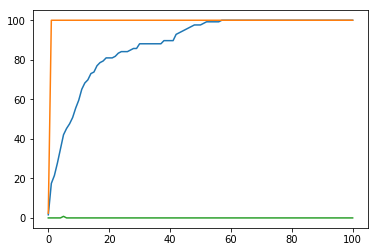

In [67]:
step = int(qq.shape[1] / 100)
qq = (q.cumsum(axis=1) / q.sum(axis=1)[:,None])[:,::step]

plt.plot(qq[0])
#plt.plot(qq[1][::step])
plt.plot(qq[2])
plt.plot(qq[1] - qq[0])
plt.xticks(range(0, 120, 20))
plt.yticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))